### Подключение библиотек и скриптов

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
from scipy.stats import shapiro
from scipy.stats import ttest_ind, mannwhitneyu
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV
import xgboost as xgb
import pickle

%config InlineBackend.figure_format = 'svg'
%matplotlib inline
plt.style.use('fivethirtyeight')

### Пути к директориям и файлам

In [2]:
DATASET_PATH = "./data/course_project_train.csv"
DATASET_PATH_TEST = "./data/course_project_test.csv"
PREP_DATASET_PATH = "./data/traning_data.csv"
MODEL_FILE_PATH = "./data/model.pkl"
DATASET_PRED_PATH = "./data/AZhilin_predictions2.csv"

### Функции

In [3]:
#Замена выбросов на медиану
#df - дата фрейм,col - колонка для замены, change_true - заменить при непопадании в интерквартильное расстояние
def del_percentile_25_75(df, col, change_true = False):
    q25 = np.percentile(df[col], 25)
    q75 = np.percentile(df[col], 75)
    iqr = q75 - q25
    if iqr or change_true:
        count_str = df.loc[df[col] < (q25 - 1.5 * iqr), col].shape[0] + df.loc[df[col] > (q75 + 1.5 * iqr), col].shape[0]
        df.loc[df[col] < (q25 - 1.5 * iqr), col] = df[col].median()
        df.loc[df[col] > (q75 + 1.5 * iqr), col] = df[col].median()
        print(f"Для столбца {col} заменено {count_str} строк - {round(count_str * 100 / df.shape[0], 2)}%")
    else:
        print(f"Не обработаны выбросы для столбцов {col}")

In [4]:
#Проверка гипотизы о схожей доли распределения значений признака в разрезе целевой переменной
#df - дата фрейм, target_name - целевая переменная, target_cat_array - массив из двух значений
def P_value_alfa(df, feature, target_name, target_cat_array):
    _target_s = df.loc[df[feature].isin(target_cat_array), ["id", feature, target_name]]
    table = _target_s.pivot_table(values="id", index=feature, columns=target_name, aggfunc='count')
    chi2, p, dof, expected = chi2_contingency(table, correction=False)
    if p < 0.05:
        print (f"достигаемый уровень значимости {p:.3f} меьше выбранного - 5%, признаки {target_cat_array} нельзя объединять")
    else:
        print (f"достигаемый уровень значимости {p:.3f} больше выбранного - 5%, признаки {target_cat_array} можно объединять")

In [5]:
#Функция для проверки распределения признака на нормальность
#df - дата фрейм,feature - признак, TARGET_NAME - целевая переменная
def equality_mat_expectations(df, feature, TARGET_NAME):
    _target_s = df[[feature, TARGET_NAME]].sample(5000)
    feature_s = _target_s[feature]
    feature_target_0 = feature_s[_target_s[TARGET_NAME] == 0]
    feature_target_1 = feature_s[_target_s[TARGET_NAME] == 1]

    if shapiro(feature_s)[1] < 0.05:
        res = mannwhitneyu(feature_target_0, feature_target_1)[1]
    else:
        res = ttest_ind(feature_target_0, feature_target_1)

    if res < 0.05:
        print(f"Гипотеза о равности матожиданий отвергается {round(res,3)}")
    else:
        print(f"Гипотеза о равности матожиданий принимается {round(res,3)}")

    plt.figure(figsize=(4, 3))
    sns.pointplot(x=TARGET_NAME, y=feature, data=_target_s, capsize=.1)
    plt.title('Confidence intervals (95 %) for ' + feature)
    plt.show()

In [6]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [7]:
def evaluate_preds(model, X_train, X_test, y_train, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

In [8]:
def balance_df_by_target(df, target_name, method='over'):

    assert method in ['over', 'under'], 'Неверный метод сэмплирования'
    
    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1
    if method == 'over':
        for i in range(disbalance_coeff):
            sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
            df = df.append(sample, ignore_index=True)
            
    elif method == 'under':
        df_ = df.copy()
        df = df_[df_[target_name] == minor_class_name]
        tmp = df_[df_[target_name] == major_class_name]
        df = df.append(tmp.iloc[
            np.random.randint(0, tmp.shape[0], target_counts[minor_class_name])
        ], ignore_index=True)

    return df.sample(frac=1) 

### Загрузка данных

In [9]:
df = pd.read_csv(DATASET_PATH)
df.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


In [10]:
df.shape

(7500, 17)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

In [12]:
df.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,3419.000000,7486.000000,7.500000e+03,7.500000e+03,7500.000000,5943.000000,7500.000000
mean,1.366392e+06,0.030133,11.130933,18.317467,9.451537e+05,0.170000,34.692600,0.117152,1.187318e+07,2.898332e+05,18314.454133,1151.087498,0.281733
std,8.453392e+05,0.271604,4.908924,7.041946,1.602622e+07,0.498598,21.688806,0.347192,3.192612e+07,3.178714e+05,11926.764673,1604.451418,0.449874
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000
25%,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.000000,16.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,711.000000,0.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,3.095730e+05,2.093230e+05,16076.500000,731.000000,0.000000
75%,1.640137e+06,0.000000,14.000000,21.800000,7.935015e+05,0.000000,50.000000,0.000000,5.198820e+05,3.604062e+05,23818.000000,743.000000,1.000000
max,1.014934e+07,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000


### Обзор данных

#### Обработка пропуcков

In [13]:
df.isna().sum()
#df.iloc[0]

Home Ownership                     0
Annual Income                   1557
Years in current job             371
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    4081
Bankruptcies                      14
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
Credit Default                     0
dtype: int64

In [14]:
#Пропуски категориального признака заменяем на моду
df.loc[df['Years in current job'].isna(), 'Years in current job'] = df['Years in current job'].mode()[0]
#Пропуски количественных ризнаков заменяем на медиану
df.loc[df['Annual Income'].isna(), 'Annual Income'] = df['Annual Income'].median()
df.loc[df['Months since last delinquent'].isna(), 'Months since last delinquent'] = df['Months since last delinquent'].median()
df.loc[df['Bankruptcies'].isna(), 'Bankruptcies'] = df['Bankruptcies'].median()
df.loc[df['Credit Score'].isna(), 'Credit Score'] = df['Credit Score'].median()

In [15]:
#Проверка заполнения
df.isna().sum()

Home Ownership                  0
Annual Income                   0
Years in current job            0
Tax Liens                       0
Number of Open Accounts         0
Years of Credit History         0
Maximum Open Credit             0
Number of Credit Problems       0
Months since last delinquent    0
Bankruptcies                    0
Purpose                         0
Term                            0
Current Loan Amount             0
Current Credit Balance          0
Monthly Debt                    0
Credit Score                    0
Credit Default                  0
dtype: int64

#### Обработка выбросов

In [16]:
TARGET_NAME = "Credit Default"
BASE_FEATURE_NAMES = df.columns.drop(TARGET_NAME).tolist()
FLOAT_FEATURE = df.select_dtypes(include = ['float64'])

for feature in FLOAT_FEATURE:
    del_percentile_25_75(df, feature)

Для столбца Annual Income заменено 516 строк - 6.88%
Не обработаны выбросы для столбцов Tax Liens
Для столбца Number of Open Accounts заменено 170 строк - 2.27%
Для столбца Years of Credit History заменено 228 строк - 3.04%
Для столбца Maximum Open Credit заменено 466 строк - 6.21%
Не обработаны выбросы для столбцов Number of Credit Problems
Не обработаны выбросы для столбцов Months since last delinquent
Не обработаны выбросы для столбцов Bankruptcies
Для столбца Current Loan Amount заменено 870 строк - 11.6%
Для столбца Current Credit Balance заменено 440 строк - 5.87%
Для столбца Monthly Debt заменено 255 строк - 3.4%
Для столбца Credit Score заменено 1003 строк - 13.37%


In [17]:
#Повторная обработка и замена значений у признаков максимальные значения которых сильно отличаются от остальных значений
for feature in ("Tax Liens", "Number of Credit Problems", "Bankruptcies"):
    del_percentile_25_75(df, feature, True)

Для столбца Tax Liens заменено 134 строк - 1.79%
Для столбца Number of Credit Problems заменено 1031 строк - 13.75%
Для столбца Bankruptcies заменено 826 строк - 11.01%


### Анализ целевой переменной

#### Обзор распределения

In [18]:
df[TARGET_NAME].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

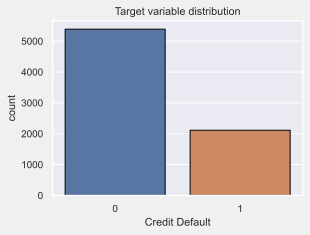

In [19]:
plt.figure(figsize=(4, 3))
sns.set(font_scale=0.9)
sns.countplot(x=TARGET_NAME, data=df, ec="black")
plt.title('Target variable distribution')
plt.show()

#### Корреляция с количественными признаками

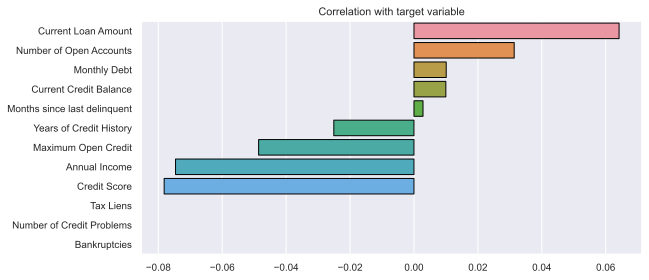

In [20]:
corr_with_target = df[BASE_FEATURE_NAMES + [TARGET_NAME]].corr().iloc[:-1, -1].sort_values(ascending=False)
plt.figure(figsize=(8, 4))
sns.barplot(x=corr_with_target.values, y=corr_with_target.index, ec="black")
plt.title('Correlation with target variable')
plt.show()

In [21]:
# После анализа корреляции оставляем только важныые признаки
BASE_FEATURE_NAMES = ['Annual Income',
 'Number of Open Accounts',
 'Years of Credit History',
 'Maximum Open Credit',
 'Months since last delinquent',
 'Current Loan Amount',
 'Current Credit Balance',
 'Monthly Debt',
 'Credit Score']

#### Обзор количественных признаков

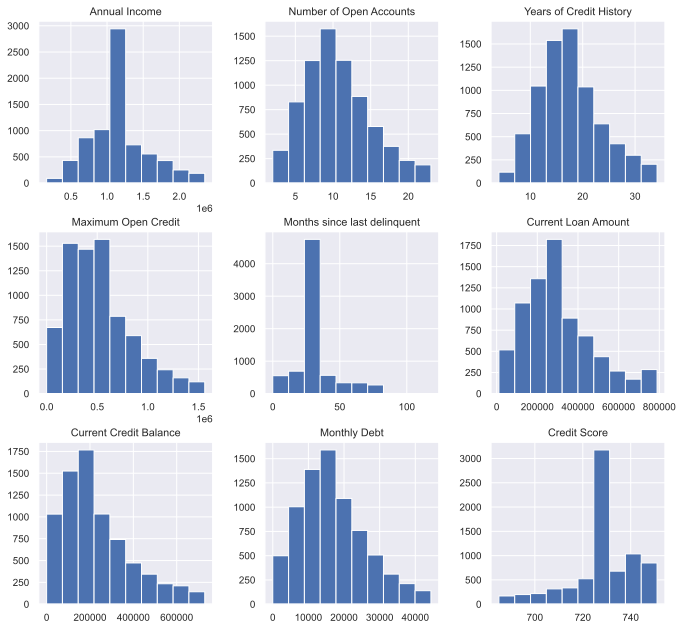

In [22]:
df[BASE_FEATURE_NAMES].hist(figsize=(10,10), bins=10);

In [23]:
# После замены выбросов и обработки пропусков видно, что в данных не существенных перекосов

#### Проверка распределения признака на нормальность

Гипотеза о равности матожиданий отвергается 0.0


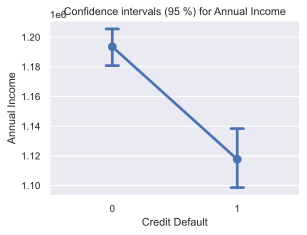

Гипотеза о равности матожиданий отвергается 0.013


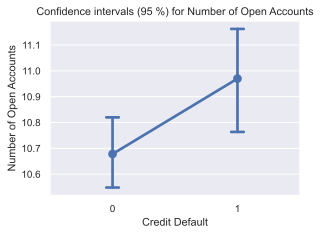

Гипотеза о равности матожиданий отвергается 0.002


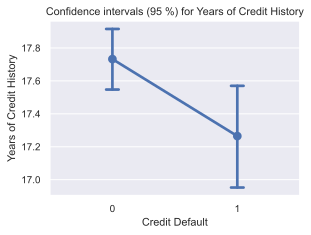

Гипотеза о равности матожиданий отвергается 0.003


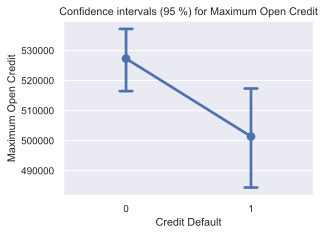

Гипотеза о равности матожиданий принимается 0.184


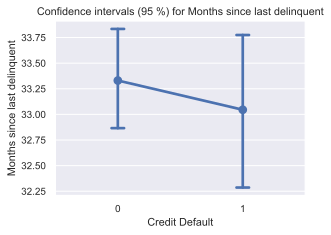

Гипотеза о равности матожиданий отвергается 0.001


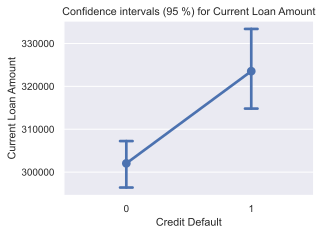

Гипотеза о равности матожиданий принимается 0.302


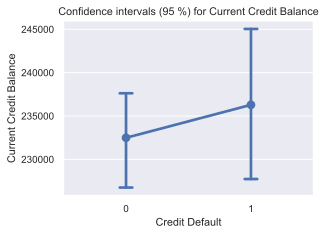

Гипотеза о равности матожиданий принимается 0.058


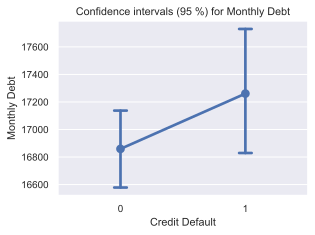

Гипотеза о равности матожиданий отвергается 0.0


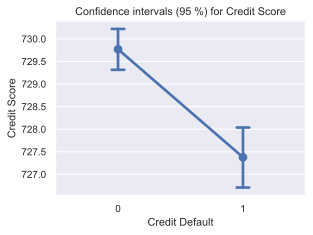

In [24]:
for feature in BASE_FEATURE_NAMES:   
    equality_mat_expectations(df, feature, TARGET_NAME)

In [25]:
# После проверки распределения признака на нормальность
BASE_FEATURE_NAMES = ['Annual Income',
 'Number of Open Accounts',
 'Maximum Open Credit',
 'Months since last delinquent',
 'Current Loan Amount',
 'Credit Score']
#'Months since last delinquent',

### Обзор категориальных признаков

In [26]:
### Приведение типов
for colname in ['Home Ownership', 'Years in current job', 'Purpose', 'Term']:
    df[colname] = df[colname].astype(str)

In [27]:
for cat_colname in df.select_dtypes(include='object').columns:
    print(str(cat_colname) + '\n\n' + str(df[cat_colname].value_counts()) + '\n' + '*' * 100 + '\n')

Home Ownership

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64
****************************************************************************************************

Years in current job

10+ years    2703
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64
****************************************************************************************************

Purpose

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation  

#### Проверка гипотиз о схожей доли распределения значений признака в разрезе целевой переменной

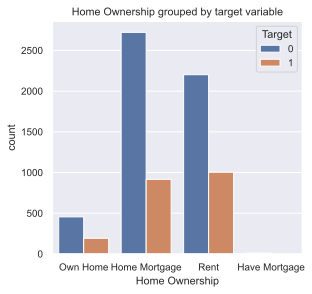

In [28]:
plt.figure(figsize=(4, 4))
sns.countplot(x="Home Ownership", hue=TARGET_NAME, data=df)
plt.title('Home Ownership grouped by target variable')
plt.legend(title='Target', loc='upper right')
plt.show()

In [29]:
df["id"] = df.index

In [30]:
P_value_alfa(df, 'Home Ownership', TARGET_NAME, ["Rent", "Own Home"])

достигаемый уровень значимости 0.414 больше выбранного - 5%, признаки ['Rent', 'Own Home'] можно объединять


In [31]:
P_value_alfa(df, 'Home Ownership', TARGET_NAME, ["Home Mortgage", "Have Mortgage"])

достигаемый уровень значимости 0.497 больше выбранного - 5%, признаки ['Home Mortgage', 'Have Mortgage'] можно объединять


In [32]:
#Замена значений
df.loc[df['Home Ownership'].isin(["Home Mortgage", "Have Mortgage"]), 'Home Ownership'] = "Mortgage"

In [33]:
#Замена значений
df.loc[df['Home Ownership'].isin(["Rent", "Own Home"]), 'Home Ownership'] = "Home_Rent"

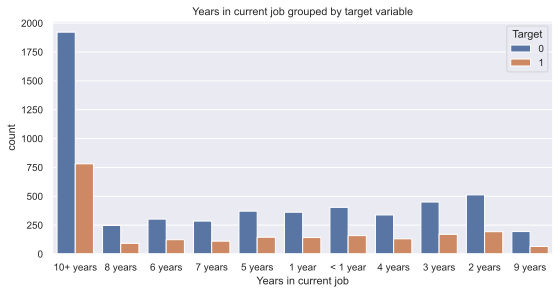

In [34]:
plt.figure(figsize=(8, 4))
sns.countplot(x="Years in current job", hue=TARGET_NAME, data=df)
plt.title('Years in current job grouped by target variable')
plt.legend(title='Target', loc='upper right')
plt.show()

In [35]:
P_value_alfa(df, 'Years in current job', TARGET_NAME, ["1 years", "2 years"])

достигаемый уровень значимости 1.000 больше выбранного - 5%, признаки ['1 years', '2 years'] можно объединять


In [36]:
P_value_alfa(df, 'Years in current job', TARGET_NAME, ["3 years", "4 years"])

достигаемый уровень значимости 0.851 больше выбранного - 5%, признаки ['3 years', '4 years'] можно объединять


In [37]:
P_value_alfa(df, 'Years in current job', TARGET_NAME, ["6 years", "7 years"])

достигаемый уровень значимости 0.733 больше выбранного - 5%, признаки ['6 years', '7 years'] можно объединять


In [38]:
P_value_alfa(df, 'Years in current job', TARGET_NAME, ["8 years", "9 years"])

достигаемый уровень значимости 0.574 больше выбранного - 5%, признаки ['8 years', '9 years'] можно объединять


In [39]:
#Замена значений
df.loc[df['Years in current job'].isin(["1 years", "2 years"]), 'Years in current job'] = "1-2 years"
df.loc[df['Years in current job'].isin(["4 years", "3 years"]), 'Years in current job'] = "3-4 years"
df.loc[df['Years in current job'].isin(["6 years", "7 years"]), 'Years in current job'] = "6-7 years"
df.loc[df['Years in current job'].isin(["8 years", "9 years"]), 'Years in current job'] = "8-9 years"

#### Построение новых Dummies признаков

In [40]:
for cat_colname in df.select_dtypes(include='object').columns[:]:
    df = pd.concat([df, pd.get_dummies(df[cat_colname], prefix=cat_colname)], axis=1)

In [41]:
DUMMIES_FEATURE_NAMES = ['Home Ownership_Home_Rent', 'Home Ownership_Mortgage',
       'Years in current job_1 year', 'Years in current job_1-2 years',
       'Years in current job_10+ years', 'Years in current job_3-4 years',
       'Years in current job_5 years', 'Years in current job_6-7 years',
       'Years in current job_8-9 years', 'Years in current job_< 1 year',
       'Purpose_business loan', 'Purpose_buy a car', 'Purpose_buy house',
       'Purpose_debt consolidation', 'Purpose_educational expenses',
       'Purpose_home improvements', 'Purpose_major purchase',
       'Purpose_medical bills', 'Purpose_moving', 'Purpose_other',
       'Purpose_renewable energy', 'Purpose_small business',
       'Purpose_take a trip', 'Purpose_vacation', 'Purpose_wedding',
       'Term_Long Term', 'Term_Short Term']

#### Корреляция с dammies признаками

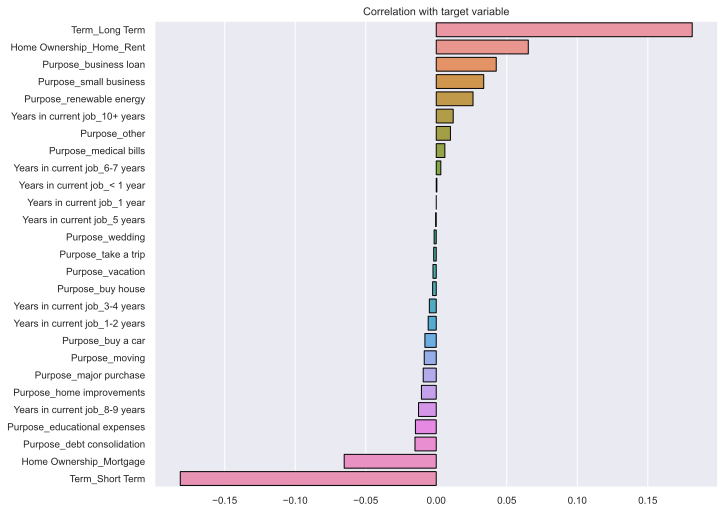

In [42]:
corr_with_target = df[DUMMIES_FEATURE_NAMES + [TARGET_NAME]].corr().iloc[:-1, -1].sort_values(ascending=False)
plt.figure(figsize=(9, 8))
sns.barplot(x=corr_with_target.values, y=corr_with_target.index, ec="black")
plt.title('Correlation with target variable')
plt.show()

In [43]:
# После анализа корреляции оставляем только важныые признаки
DUMMIES_FEATURE_NAMES = ['Home Ownership_Home_Rent', 'Home Ownership_Mortgage',
       'Purpose_business loan', 'Purpose_small business',
       'Purpose_debt consolidation', 'Purpose_educational expenses',
       'Purpose_renewable energy',
       'Term_Long Term', 'Term_Short Term']

#### Проверка распределения dummies признаков на нормальность

Гипотеза о равности матожиданий отвергается 0.0


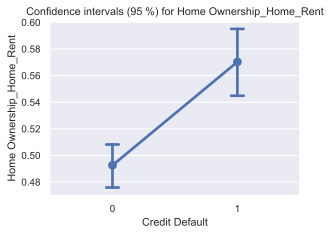

Гипотеза о равности матожиданий отвергается 0.0


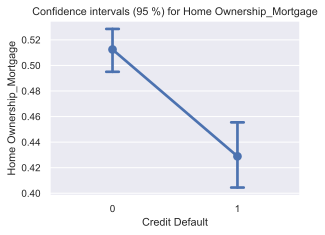

Гипотеза о равности матожиданий отвергается 0.0


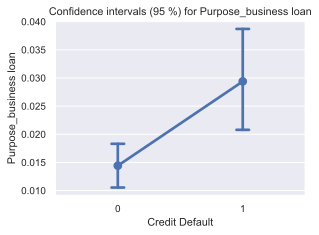

Гипотеза о равности матожиданий отвергается 0.033


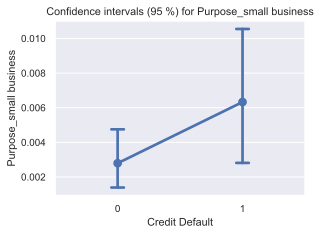

Гипотеза о равности матожиданий принимается 0.055


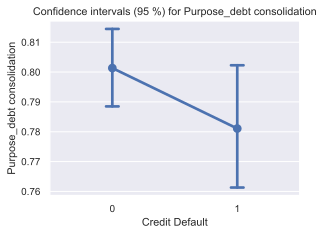

Гипотеза о равности матожиданий принимается 0.169


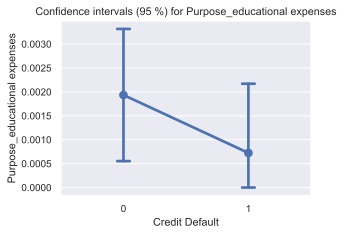

Гипотеза о равности матожиданий принимается 0.058


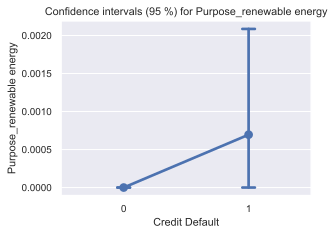

Гипотеза о равности матожиданий отвергается 0.0


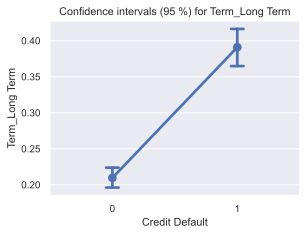

Гипотеза о равности матожиданий отвергается 0.0


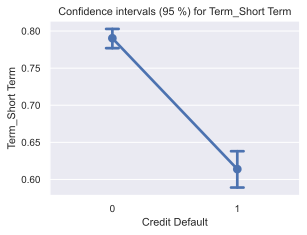

In [44]:
 for feature in DUMMIES_FEATURE_NAMES: 
    equality_mat_expectations(df, feature, TARGET_NAME)

In [45]:
# После проверки распределения признака на нормальность
DUMMIES_FEATURE_NAMES = ['Home Ownership_Home_Rent', 'Home Ownership_Mortgage',
       'Purpose_business loan', 'Purpose_small business',
       'Purpose_educational expenses',
       'Term_Long Term', 'Term_Short Term']

### Корреляция полученных признаков

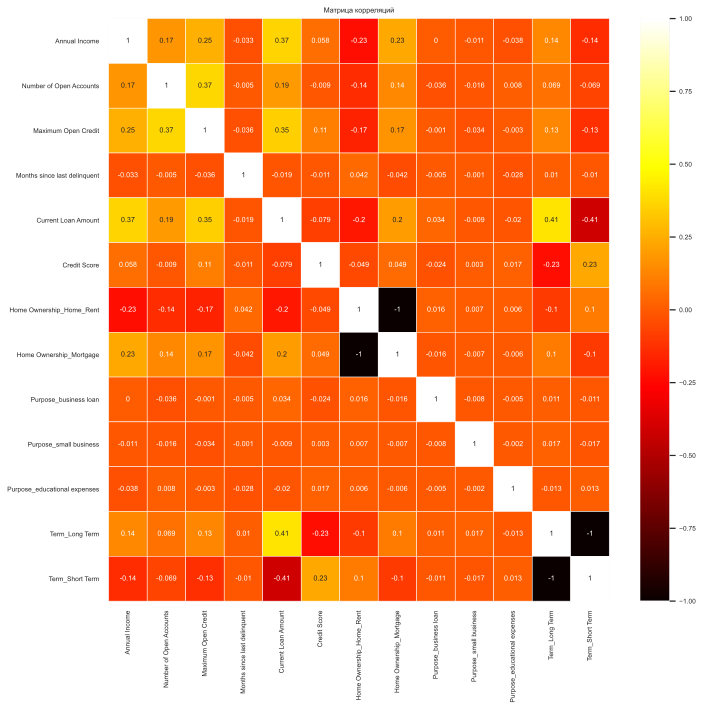

In [46]:
#Нахождение наиболее коррелирующих признаков
plt.figure(figsize = (10,10))
sns.set(font_scale=0.6)
sns.heatmap(df[BASE_FEATURE_NAMES + DUMMIES_FEATURE_NAMES].corr().round(3), annot=True, linewidths=.5, cmap='hot')
plt.title("Матрица корреляций");

In [47]:
#Можно отметить тесную корреляцию у признаков:
#Home Ownership_Home_Rent, Home Ownership_Mortgage
#Term_Long Term, Term_Short Term

### Сохранение датасета

In [48]:
df.to_csv(PREP_DATASET_PATH, index=False, encoding='utf-8')

### Обучение модели

In [49]:
df = pd.read_csv(PREP_DATASET_PATH)

#### Разбиение выборки на тренировочную и тестовую

In [50]:
X = df[BASE_FEATURE_NAMES + DUMMIES_FEATURE_NAMES]
y = df[TARGET_NAME]

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    shuffle=True,
                                                    test_size=0.3,
                                                    random_state=10,
                                                    stratify=y
                                                   )

display(y_train.value_counts(normalize=True), y_test.value_counts(normalize=True))

0    0.718286
1    0.281714
Name: Credit Default, dtype: float64

0    0.718222
1    0.281778
Name: Credit Default, dtype: float64

#### Балансировка классов

In [51]:
df_for_balancing = pd.concat([X_train, y_train], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, TARGET_NAME, method='under') 
df_balanced[TARGET_NAME].value_counts()

0    1479
1    1479
Name: Credit Default, dtype: int64

In [52]:
#Балансировка для обучающей выборки
X_train = df_balanced.drop(columns=TARGET_NAME)
y_train = df_balanced[TARGET_NAME]

#### Построение модели

In [53]:
%%time
model_xgb = xgb.XGBClassifier(random_state=40, 
                              n_estimators=200, max_depth=5
                             )
model_xgb.fit(X_train, y_train)
evaluate_preds(model_xgb, X_train, X_test, y_train, y_test)

TRAIN

              precision    recall  f1-score   support

           0       0.91      0.89      0.90      1479
           1       0.90      0.91      0.90      1479

    accuracy                           0.90      2958
   macro avg       0.90      0.90      0.90      2958
weighted avg       0.90      0.90      0.90      2958

TEST

              precision    recall  f1-score   support

           0       0.82      0.61      0.70      1616
           1       0.40      0.67      0.50       634

    accuracy                           0.63      2250
   macro avg       0.61      0.64      0.60      2250
weighted avg       0.71      0.63      0.64      2250

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               984  632
1               210  424
Wall time: 375 ms


#### Подбор гиперпараметров

In [54]:
params = {'n_estimators':[100, 200, 300], 
          'max_depth':[3, 5, 7, 9, 12]}

In [55]:
best_param_xgb = GridSearchCV(model_xgb, params, scoring='f1', cv=5, n_jobs=-1)
best_param_xgb.fit(X_train, y_train)
best_param_xgb.best_params_

{'max_depth': 9, 'n_estimators': 100}

In [56]:
# Максимальной f1 score для предсказания невыплат (значение 1) - n_estimators=100, max_depth=3")

In [57]:
# %%time
final_model = xgb.XGBClassifier(random_state=40, n_estimators=100, max_depth=3)
final_model.fit(X_train, y_train)
evaluate_preds(final_model, X_train, X_test, y_train, y_test)

TRAIN

              precision    recall  f1-score   support

           0       0.77      0.71      0.74      1479
           1       0.73      0.79      0.76      1479

    accuracy                           0.75      2958
   macro avg       0.75      0.75      0.75      2958
weighted avg       0.75      0.75      0.75      2958

TEST

              precision    recall  f1-score   support

           0       0.84      0.62      0.71      1616
           1       0.42      0.70      0.53       634

    accuracy                           0.64      2250
   macro avg       0.63      0.66      0.62      2250
weighted avg       0.72      0.64      0.66      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1001  615
1                189  445


In [58]:
#Таким образом получаем f1 score для предсказания невозврата кредита на тестовых данных > 0.5

### Сохранение финальной модели

In [59]:
with open(MODEL_FILE_PATH, 'wb') as file:
    pickle.dump(final_model, file)

## Предсказание возврата кредита на тестовых данных

In [60]:
df_final = pd.read_csv(DATASET_PATH_TEST)

#### Обработка пропусков

In [61]:
df_final.isna().sum()

Home Ownership                     0
Annual Income                    513
Years in current job              86
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    1358
Bankruptcies                       3
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                     513
dtype: int64

In [62]:
df_final.loc[df_final['Years in current job'].isna(), 'Years in current job'] = df_final['Years in current job'].mode()[0]
df_final.loc[df_final['Annual Income'].isna(), 'Annual Income'] = df_final['Annual Income'].median()
df_final.loc[df_final['Months since last delinquent'].isna(), 'Months since last delinquent'] = df_final['Months since last delinquent'].median()
df_final.loc[df_final['Bankruptcies'].isna(), 'Bankruptcies'] = df_final['Bankruptcies'].median()
df_final.loc[df_final['Credit Score'].isna(), 'Credit Score'] = df_final['Credit Score'].median()

In [63]:
df_final.isna().sum()

Home Ownership                  0
Annual Income                   0
Years in current job            0
Tax Liens                       0
Number of Open Accounts         0
Years of Credit History         0
Maximum Open Credit             0
Number of Credit Problems       0
Months since last delinquent    0
Bankruptcies                    0
Purpose                         0
Term                            0
Current Loan Amount             0
Current Credit Balance          0
Monthly Debt                    0
Credit Score                    0
dtype: int64

#### Обработка выбросов

In [64]:
FLOAT_FEATURE = df_final.select_dtypes(include = ['float64'])

for feature in FLOAT_FEATURE:
    del_percentile_25_75(df_final, feature)

Для столбца Annual Income заменено 176 строк - 7.04%
Не обработаны выбросы для столбцов Tax Liens
Для столбца Number of Open Accounts заменено 46 строк - 1.84%
Для столбца Years of Credit History заменено 70 строк - 2.8%
Для столбца Maximum Open Credit заменено 156 строк - 6.24%
Не обработаны выбросы для столбцов Number of Credit Problems
Не обработаны выбросы для столбцов Months since last delinquent
Не обработаны выбросы для столбцов Bankruptcies
Для столбца Current Loan Amount заменено 297 строк - 11.88%
Для столбца Current Credit Balance заменено 125 строк - 5.0%
Для столбца Monthly Debt заменено 69 строк - 2.76%
Для столбца Credit Score заменено 325 строк - 13.0%


#### Создание Dammies признаков

In [65]:
BASE_FEATURE_NAMES = ['Annual Income',
 'Number of Open Accounts',
 'Maximum Open Credit',
 'Months since last delinquent',
 'Current Loan Amount',
 'Credit Score']

DUMMIES_FEATURE_NAMES = ['Home Ownership_Home_Rent', 'Home Ownership_Mortgage',
       'Purpose_business loan', 'Purpose_small business',
       'Purpose_educational expenses',
       'Term_Long Term', 'Term_Short Term']

feature_names = BASE_FEATURE_NAMES + DUMMIES_FEATURE_NAMES

In [66]:
#Замена значений
df_final.loc[df_final['Home Ownership'].isin(["Home Mortgage", "Have Mortgage"]), 'Home Ownership'] = "Mortgage"
df_final.loc[df_final['Home Ownership'].isin(["Rent", "Own Home"]), 'Home Ownership'] = "Home_Rent"

In [67]:
for colname in ['Home Ownership', 'Years in current job', 'Purpose', 'Term']:
    df[colname] = df_final[colname].astype(str)

#### Предсказание возврата кредита

In [68]:
X_final = pd.DataFrame(df_final, columns=feature_names)
y_final_preds = final_model.predict(X_final)

#### Сохранение файла с предсказанием

In [69]:
df_final["Id"] = df_final.index
df_y_pred = pd.DataFrame({'Id': df_final['Id'],'Credit Default' : y_final_preds})
df_y_pred.to_csv(DATASET_PRED_PATH, index=False, encoding='utf-8')
df_y_pred.head()

,Id,Credit Default
0,0,0
1,1,1
2,2,1
3,3,0
4,4,0
